In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import json

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# ValueError: could not convert string to float: '8789-0'
def read_data_partial(given_fname, output_fname, lim=20000):
    content = []
    count = 1

    with open(given_fname, 'r') as fr:
        for line in fr:
            if count <= lim:
                #print(type(line), line)
                content.append(line)
                count += 1
    with open(output_fname, 'w') as fw:
        for line in content:
            # print(type(line), line)
            fw.write(line)
    
    data = pd.read_csv(output_fname, index_col=False)

    return data

In [3]:
qso_train_partial = read_data_partial('quasar_train_catalog.csv', 'qso_train_partial.csv')
print('qso_train_catalog.csv partial data description: ')
qso_train_partial.describe()

qso_train_catalog.csv partial data description: 


,ra_d,dec_d,z,u_LSST_mag,u_LSST_magerr,g_LSST_mag,g_LSST_magerr,r_LSST_mag,r_LSST_magerr,i_LSST_mag,...,y_LSST_mag,y_LSST_magerr,Y_WFI_mag,Y_WFI_magerr,J_WFI_mag,J_WFI_magerr,H_WFI_mag,H_WFI_magerr,F_WFI_mag,F_WFI_magerr
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,...,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,23.623792,-22.262561,7.999811,99.164311,0.091043,98.638451,0.205693,83.708411,0.652219,56.014640,...,38.686915,3.220267,22.667320,0.422618,18.249912,0.010070,17.991365,0.010060,17.924648,0.010103
std,13.673958,13.470843,1.154848,7.623070,3.252917,9.636021,9.258799,30.350312,27.306826,36.410617,...,31.606316,187.985892,10.687478,10.845862,0.144553,0.000095,0.344047,0.000094,0.354783,0.000099
min,0.001002,-47.495711,6.000196,26.765039,0.000000,27.911082,0.000000,22.470212,0.000000,20.720397,...,17.907592,0.000000,17.958488,0.000000,17.975591,0.009674,16.702080,0.009707,16.475177,0.009701
25%,11.645229,-33.527219,6.999971,99.990000,0.000000,99.990000,0.000000,99.990000,0.000000,25.028411,...,18.943982,0.010414,18.566404,0.010093,18.124439,0.010005,17.823141,0.009996,17.735487,0.010036
50%,23.594917,-21.578934,7.999920,99.990000,0.000000,99.990000,0.000000,99.990000,0.000000,29.389093,...,25.259249,0.011343,19.349044,0.010231,18.251091,0.010069,18.066165,0.010060,17.993070,0.010102
75%,35.422686,-10.572103,8.999614,99.990000,0.000000,99.990000,0.000000,99.990000,0.000000,99.990000,...,28.266166,0.560991,24.374057,0.018531,18.374454,0.010133,18.243405,0.010124,18.180132,0.010169
max,47.497256,-0.000376,9.999744,99.990000,285.052158,99.990000,878.110221,99.990000,2836.799364,99.990000,...,99.990000,26004.534629,99.990000,1291.885585,18.525293,0.010423,18.651787,0.010430,18.738388,0.010521


In [4]:
# brown dwarf contaminants
mlt_train_partial = read_data_partial('mlt_train_catalog.csv', 'mlt_train_partial.csv')
print('mlt_train_catalog.csv partial data description: ')
mlt_train_partial.describe()

mlt_train_catalog.csv partial data description: 


,ra_d,dec_d,spt,u_LSST_mag,u_LSST_magerr,g_LSST_mag,g_LSST_magerr,r_LSST_mag,r_LSST_magerr,i_LSST_mag,...,y_LSST_mag,y_LSST_magerr,Y_WFI_mag,Y_WFI_magerr,J_WFI_mag,J_WFI_magerr,H_WFI_mag,H_WFI_magerr,F_WFI_mag,F_WFI_magerr
count,19999.000000,19999.000000,19999.000000,1.999900e+04,19999.0,1.999900e+04,19999.0,19999.000000,19999.000000,19999.000000,...,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,23.604072,-22.261228,4.936797,9.999000e+01,0.0,9.999000e+01,0.0,24.416302,0.020199,19.872187,...,18.550723,0.010603,18.398234,0.010083,18.146058,0.010062,18.037319,0.010061,18.142713,0.010119
std,13.705803,13.505142,0.251022,8.540937e-12,0.0,8.540937e-12,0.0,0.182280,0.001938,0.142525,...,0.140613,0.000146,0.141465,0.000094,0.143001,0.000094,0.144039,0.000095,0.141402,0.000096
min,0.001930,-47.499684,3.000000,9.999000e+01,0.0,9.999000e+01,0.0,23.472924,0.013136,19.108723,...,18.098625,0.010041,17.893173,0.009737,17.674221,0.009702,17.560797,0.009668,17.670703,0.009760
25%,11.705409,-33.465227,5.000000,9.999000e+01,0.0,9.999000e+01,0.0,24.334772,0.018985,19.777932,...,18.454311,0.010503,18.301993,0.010020,18.049020,0.009998,17.939912,0.009996,18.046667,0.010054
50%,23.631542,-21.691304,5.000000,9.999000e+01,0.0,9.999000e+01,0.0,24.433813,0.020168,19.871827,...,18.547176,0.010598,18.393954,0.010082,18.140592,0.010061,18.031482,0.010060,18.136810,0.010118
75%,35.444491,-10.547422,5.000000,9.999000e+01,0.0,9.999000e+01,0.0,24.530030,0.021422,19.966675,...,18.643236,0.010697,18.487967,0.010146,18.235301,0.010125,18.127651,0.010124,18.234207,0.010184
max,47.487130,-0.000214,5.000000,9.999000e+01,0.0,9.999000e+01,0.0,25.108104,0.028811,20.899200,...,19.597340,0.011930,19.603275,0.010474,19.237794,0.010491,19.127854,0.010468,19.231066,0.010537


In [5]:
galaxies_patch8789_partial = read_data_partial('galaxies_train_catalog_patch8789.csv', 'galaxies_patch8789_partial.csv')
print('galaxies_train_catalog_patch8789.csv partial data description: ')
galaxies_patch8789_partial.describe()

galaxies_train_catalog_patch8789.csv partial data description: 


,ra_d,dec_d,z,redsq_flag,u_LSST_mag,u_LSST_magerr,g_LSST_mag,g_LSST_magerr,r_LSST_mag,r_LSST_magerr,...,z_LSST_mag,z_LSST_magerr,Y_WFI_mag,Y_WFI_magerr,J_WFI_mag,J_WFI_magerr,H_WFI_mag,H_WFI_magerr,F_WFI_mag,F_WFI_magerr
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,...,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,23.878705,-22.182163,1.029736,0.206060,32.096210,0.841619,27.163475,0.365798,25.867251,0.086984,...,24.665585,0.103122,24.393170,0.047201,24.257111,0.041552,24.143105,0.041009,24.097952,0.068160
std,13.681795,13.538485,0.013707,0.404484,19.985380,8.052372,7.995741,11.988124,2.446110,0.273719,...,2.360016,0.326791,1.390669,0.077989,1.525714,0.041961,1.372470,0.040619,1.855994,0.311219
min,0.000400,-47.490719,1.005989,0.000000,20.885667,0.000000,21.017643,0.000000,21.061000,0.000000,...,20.251427,0.000000,19.714550,0.000000,19.313884,0.000000,18.971237,0.010012,18.749711,0.000000
25%,12.078150,-33.422642,1.018022,0.000000,25.268505,0.060758,25.333199,0.036689,24.983450,0.026726,...,23.871939,0.034156,23.650510,0.020292,23.493042,0.018506,23.372548,0.017841,23.296980,0.023390
50%,23.957857,-21.268991,1.030270,0.000000,26.503441,0.193694,26.418137,0.082988,25.941315,0.050624,...,24.740292,0.063615,24.545892,0.033595,24.424274,0.030043,24.329182,0.029424,24.277466,0.043752
75%,35.765324,-10.507017,1.040617,0.000000,27.615922,0.475728,27.355587,0.181539,26.707190,0.092916,...,25.467804,0.115342,25.283910,0.056736,25.188414,0.050689,25.119557,0.050084,25.074150,0.080108
max,47.499362,-0.001712,1.055213,1.000000,99.990000,610.729321,99.990000,1616.793763,99.990000,27.122388,...,99.990000,24.843754,99.990000,8.171002,99.990000,1.879305,28.627669,1.148440,99.990000,40.846061


In [6]:
galaxies_patch8786_partial = read_data_partial('galaxies_train_catalog_patch8786.csv', 'galaxies_patch8786_partial.csv')
print('galaxies_train_catalog_patch8786.csv partial data description: ')
galaxies_patch8786_partial.describe()

galaxies_train_catalog_patch8786.csv partial data description: 


,ra_d,dec_d,z,redsq_flag,u_LSST_mag,u_LSST_magerr,g_LSST_mag,g_LSST_magerr,r_LSST_mag,r_LSST_magerr,...,y_LSST_mag,y_LSST_magerr,Y_WFI_mag,Y_WFI_magerr,J_WFI_mag,J_WFI_magerr,H_WFI_mag,H_WFI_magerr,F_WFI_mag,F_WFI_magerr
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,...,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,23.861391,-22.220777,1.033303,0.207710,32.076440,0.902327,27.211979,0.380718,25.851356,0.088822,...,25.221141,0.399308,24.361144,0.046372,24.219740,0.041185,24.111885,0.040571,24.051143,0.065607
std,13.730388,13.446906,0.013441,0.405678,19.986324,8.611686,8.326998,11.659733,2.517689,0.307329,...,7.801614,7.439558,1.312732,0.045483,1.353944,0.037782,1.402496,0.038762,1.544440,0.090881
min,0.000071,-47.499394,1.005990,0.000000,20.511595,0.000000,20.689145,0.000000,20.749999,0.000000,...,19.776906,0.000000,19.571055,0.010152,19.165246,0.010151,18.841577,0.010053,18.619593,0.000000
25%,11.862930,-33.452881,1.023309,0.000000,25.265173,0.057836,25.334869,0.036408,24.961529,0.026510,...,23.664300,0.072782,23.602897,0.019855,23.443356,0.018111,23.313647,0.017441,23.232343,0.022583
50%,23.977822,-21.484245,1.033333,0.000000,26.509003,0.197169,26.402710,0.082021,25.929260,0.050329,...,24.574696,0.157360,24.531609,0.033312,24.416682,0.029878,24.321447,0.029093,24.272070,0.043334
75%,35.794271,-10.561793,1.045235,0.000000,27.604059,0.477124,27.339770,0.178356,26.703131,0.092701,...,25.323580,0.305534,25.281628,0.056255,25.179444,0.050102,25.107016,0.049410,25.066376,0.079415
max,47.496472,-0.001413,1.055212,1.000000,99.990000,605.642904,99.990000,1492.010952,99.990000,30.285473,...,99.990000,979.763106,29.062647,1.628481,28.248498,0.767126,28.574002,1.177792,99.990000,5.245063


## drop u and g bands

In [7]:
qso_train_drop = qso_train_partial.copy(deep=True)
mlt_train_drop = mlt_train_partial.copy(deep=True)
galaxies_patch8789_drop = galaxies_patch8789_partial.copy(deep=True)
galaxies_patch8786_drop = galaxies_patch8786_partial.copy(deep=True)

# drop y bands due to varying band depth
qso_train_drop = qso_train_drop[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
mlt_train_drop = mlt_train_drop[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag','Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8789_drop = galaxies_patch8789_drop[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8786_drop = galaxies_patch8786_drop[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag','Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]

In [8]:
print(mlt_train_drop.head())

   r_LSST_mag  i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  \
0   23.771728   19.188742   18.619318  18.234199  18.173076  18.075345   
1   24.057291   19.349954   18.518527  18.288840  18.190218  17.931068   
2   23.800163   19.231461   18.658050  18.124577  18.069681  18.094448   
3   23.875277   19.292420   18.613907  18.302484  18.055089  17.946084   
4   23.916246   19.295319   18.665239  18.207935  18.128765  18.094981   

   F_WFI_mag  
0  18.112094  
1  18.153265  
2  17.930868  
3  17.947154  
4  18.246019  


### replace missing values with mean

In [9]:
# add labels
qso_train_drop['label'] = np.ones(len(qso_train_drop))
qso_train_drop = qso_train_drop.replace(99.99, np.nan)
qso_drop_replace = {}
for col in qso_train_drop.columns:
    qso_train_drop[col] = qso_train_drop[col].replace([np.nan], round(qso_train_drop[col].mean(), 6))
    qso_drop_replace[col] = round(qso_train_drop[col].mean(), 6)
print(qso_drop_replace, '\n', len(qso_drop_replace))

{'r_LSST_mag': 27.22676, 'i_LSST_mag': 26.010927, 'z_LSST_mag': 24.839597, 'Y_WFI_mag': 21.386011, 'J_WFI_mag': 18.249912, 'H_WFI_mag': 17.991365, 'F_WFI_mag': 17.924648, 'label': 1.0} 
 8


In [10]:
qso_train_drop.describe()

,r_LSST_mag,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.0
mean,27.226760,26.010927,24.839597,21.386011,18.249912,17.991365,17.924648,1.0
std,1.218378,2.498598,3.061913,3.891398,0.144553,0.344047,0.354783,0.0
min,22.470212,20.720397,18.073481,17.958488,17.975591,16.702080,16.475177,1.0
25%,27.226760,25.028411,23.179025,18.566404,18.124439,17.823141,17.735487,1.0
50%,27.226760,26.010927,24.839597,19.349044,18.251091,18.066165,17.993070,1.0
75%,27.226760,27.518055,27.407699,23.478432,18.374454,18.243405,18.180132,1.0
max,37.997592,36.747255,37.357355,36.484241,18.525293,18.651787,18.738388,1.0


In [11]:
print(np.where(np.isnan(qso_train_drop)))

(array([], dtype=int64), array([], dtype=int64))


In [12]:
mlt_train_drop['label'] = np.zeros(len(mlt_train_drop))
mlt_drop_replace = {}
for col in mlt_train_drop.columns:
    mlt_train_drop[col] = mlt_train_drop[col].replace([np.nan], round(mlt_train_drop[col].mean(), 6))
    mlt_drop_replace[col] = round(mlt_train_drop[col].mean(), 6)
print(mlt_drop_replace, '\n', len(mlt_drop_replace))
print(np.where(np.isnan(mlt_train_drop)))

{'r_LSST_mag': 24.416302, 'i_LSST_mag': 19.872187, 'z_LSST_mag': 19.014882, 'Y_WFI_mag': 18.398234, 'J_WFI_mag': 18.146058, 'H_WFI_mag': 18.037319, 'F_WFI_mag': 18.142713, 'label': 0.0} 
 8
(array([], dtype=int64), array([], dtype=int64))


In [13]:
galaxies_patch8789_drop['label'] = np.zeros(len(galaxies_patch8789_drop))
galaxies_patch8789_drop = galaxies_patch8789_drop.replace(99.99, np.nan)
patch8789_drop_replace = {}
for col in galaxies_patch8789_drop.columns:
    galaxies_patch8789_drop[col] = galaxies_patch8789_drop[col].replace([np.nan], round(galaxies_patch8789_drop[col].mean(), 6))
    patch8789_drop_replace[col] = round(galaxies_patch8789_drop[col].mean(), 6)
print(patch8789_drop_replace, '\n', len(patch8789_drop_replace))
print(np.where(np.isnan(galaxies_patch8789_drop)))

{'r_LSST_mag': 25.811614, 'i_LSST_mag': 25.210954, 'z_LSST_mag': 24.612818, 'Y_WFI_mag': 24.38939, 'J_WFI_mag': 24.249537, 'H_WFI_mag': 24.143105, 'F_WFI_mag': 24.078974, 'label': 0.0} 
 8
(array([], dtype=int64), array([], dtype=int64))


In [14]:
galaxies_patch8786_drop['label'] = np.zeros(len(galaxies_patch8786_drop))
galaxies_patch8786_drop = galaxies_patch8786_drop.replace(99.99, np.nan)
patch8786_drop_replace = {}
for col in galaxies_patch8786_drop.columns:
    galaxies_patch8786_drop[col] = galaxies_patch8786_drop[col].replace([np.nan], round(galaxies_patch8786_drop[col].mean(), 6))
    patch8786_drop_replace[col] = round(galaxies_patch8786_drop[col].mean(), 6)
print(patch8786_drop_replace, '\n', len(patch8786_drop_replace))
print(np.where(np.isnan(galaxies_patch8786_drop)))

{'r_LSST_mag': 25.791994, 'i_LSST_mag': 25.196621, 'z_LSST_mag': 24.588757, 'Y_WFI_mag': 24.361144, 'J_WFI_mag': 24.21974, 'H_WFI_mag': 24.111885, 'F_WFI_mag': 24.047345, 'label': 0.0} 
 8
(array([], dtype=int64), array([], dtype=int64))


### drop missing values

In [9]:
qso_train_drop = qso_train_drop.replace(99.99, np.nan).dropna()
mlt_train_drop = mlt_train_drop.replace(99.99, np.nan).dropna()
galaxies_patch8789_drop = galaxies_patch8789_drop.replace(99.99, np.nan).dropna()
galaxies_patch8786_drop = galaxies_patch8786_drop.replace(99.99, np.nan).dropna()

print(qso_train_drop.head(), len(qso_train_drop))
print(np.where(np.isnan(qso_train_drop)))
print(len(mlt_train_drop))
print(np.where(np.isnan(mlt_train_drop)))
print(len(galaxies_patch8789_drop))
print(np.where(np.isnan(galaxies_patch8789_drop)))
print(len(galaxies_patch8786_drop))
print(np.where(np.isnan(galaxies_patch8786_drop)))

   r_LSST_mag  i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  \
0   23.264536   21.124055   18.554360  18.128561  18.023118  17.887595   
1   22.749456   20.809598   18.341480  18.051626  18.089177  18.128696   
2   23.423308   21.433489   18.603074  18.187806  18.020838  17.793332   
3   23.340448   21.204065   18.452523  18.136504  18.066659  17.968268   
4   23.158449   20.894110   18.271392  18.043841  18.061578  18.047223   

   F_WFI_mag  
0  17.631285  
1  18.004063  
2  17.472947  
3  17.731981  
4  17.902222   4402
(array([], dtype=int64), array([], dtype=int64))
19999
(array([], dtype=int64), array([], dtype=int64))
19958
(array([], dtype=int64), array([], dtype=int64))
19961
(array([], dtype=int64), array([], dtype=int64))


In [10]:
qso_train_drop['label'] = np.ones(len(qso_train_drop))
mlt_train_drop['label'] = np.zeros(len(mlt_train_drop))
galaxies_patch8789_drop['label'] = np.zeros(len(galaxies_patch8789_drop))
galaxies_patch8786_drop['label'] = np.zeros(len(galaxies_patch8786_drop))

### check the cleaned datasets and concatenate into new ones

In [11]:
print('qso:\n', qso_train_drop.head())
print('bd:\n', mlt_train_drop.head())
print('galaxies patch8789:\n', galaxies_patch8789_drop.head())
print('galaxies path8786:\n', galaxies_patch8786_drop.head())

qso:
    r_LSST_mag  i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  \
0   23.264536   21.124055   18.554360  18.128561  18.023118  17.887595   
1   22.749456   20.809598   18.341480  18.051626  18.089177  18.128696   
2   23.423308   21.433489   18.603074  18.187806  18.020838  17.793332   
3   23.340448   21.204065   18.452523  18.136504  18.066659  17.968268   
4   23.158449   20.894110   18.271392  18.043841  18.061578  18.047223   

   F_WFI_mag  label  
0  17.631285    1.0  
1  18.004063    1.0  
2  17.472947    1.0  
3  17.731981    1.0  
4  17.902222    1.0  
bd:
    r_LSST_mag  i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  \
0   23.771728   19.188742   18.619318  18.234199  18.173076  18.075345   
1   24.057291   19.349954   18.518527  18.288840  18.190218  17.931068   
2   23.800163   19.231461   18.658050  18.124577  18.069681  18.094448   
3   23.875277   19.292420   18.613907  18.302484  18.055089  17.946084   
4   23.916246   19.295319   18.665239  18.

In [12]:
# data concatenation to get training data
contaminants_drop = pd.concat([mlt_train_drop, galaxies_patch8789_drop, galaxies_patch8786_drop], ignore_index=True)
data_train_drop = pd.concat([qso_train_drop, contaminants_drop], ignore_index=True) # make sure that the data line up
X_drop = data_train_drop[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag','Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
Y_drop = data_train_drop['label']

In [13]:
print(len(X_drop))

64320


### with mean values dropped

22 < i < 24

In [14]:
X_drop_between = X_drop[X_drop['i_LSST_mag'] < 24.0]
X_drop_between = X_drop_between[X_drop_between['i_LSST_mag'] > 22.0]
Y_drop_between = data_train_drop[data_train_drop['i_LSST_mag'] < 24.0]
Y_drop_between = Y_drop_between[Y_drop_between['i_LSST_mag'] > 22.0]['label']
col_names = ['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']
for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i < j:
            col = col_names[i] + '-' + col_names[j]
            X_drop_between[col] = X_drop_between[col_names[i]] - X_drop_between[col_names[j]]

In [15]:
#X_drop_between_copy = X_drop_between.copy()
X_drop_between_copy = X_drop_between.drop(columns=['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag'])

/data0/sw/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


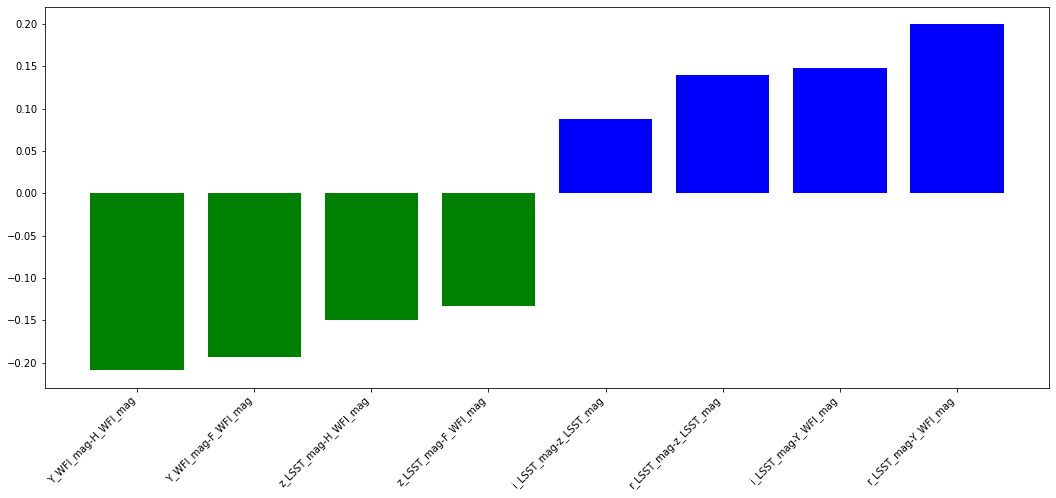

In [16]:
trainedsvm = svm.LinearSVC(max_iter = 2000).fit(X_drop_between_copy, Y_drop_between)
coef = trainedsvm.coef_.ravel()

top_positive_coefficients = np.argsort(coef)[-4:]
top_negative_coefficients = np.argsort(coef)[:4]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
plt.figure(figsize=(18, 7))
colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * 4), coef[top_coefficients], color=colors)
feature_names = np.array(X_drop_between_copy.columns)
plt.xticks(np.arange(2 * 4), feature_names[top_coefficients], rotation=45, ha='right')
plt.show()

'z_LSST_mag-F_WFI_mag', 'z_LSST_mag-H_WFI_mag', 'r_LSST_mag-Y_WFI_mag', 'i_LSST_mag-z_LSST_mag', 'r_LSST_mag-J_WFI_mag', 'r_LSST_mag-z_LSST_mag'

replacing NaN with mean: 'Y_WFI_mag-H_WFI_mag', 'Y_WFI_mag-F_WFI_mag', 'Y_WFI_mag-J_WFI_mag', 'z_LSST_mag-H_WFI_mag', 'r_LSST_mag-z_LSST_mag', 'i_LSST_mag-Y_WFI_mag', 'r_LSST_mag-Y_WFI_mag'

In [17]:
# keep the columns with the highest influences & check if the dataframes look reasonable
# with i-band limits
X_drop_between = X_drop_between[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'Y_WFI_mag-H_WFI_mag', 'Y_WFI_mag-F_WFI_mag', 'z_LSST_mag-H_WFI_mag', 'z_LSST_mag-F_WFI_mag', 'i_LSST_mag-z_LSST_mag', 'r_LSST_mag-z_LSST_mag', 'i_LSST_mag-Y_WFI_mag', 'r_LSST_mag-Y_WFI_mag']]

print(type(X_drop_between))
print('X with 22.0 < i < 24.0: \n', X_drop_between.head())

<class 'pandas.core.frame.DataFrame'>
X with 22.0 < i < 24.0: 
      r_LSST_mag  i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  \
250   24.742821   22.094462   18.874546  18.141918  18.092987  18.074826   
304   25.848806   22.030592   19.422444  18.264333  18.076935  17.984105   
306   25.643431   22.038840   19.404501  18.273683  18.043071  17.844302   
310   25.614387   22.020449   19.134073  18.132919  17.997342  17.920215   
313   25.498590   22.068718   19.220210  18.246276  18.091573  17.966831   

     F_WFI_mag  Y_WFI_mag-H_WFI_mag  Y_WFI_mag-F_WFI_mag  \
250  17.924192             0.067092             0.217726   
304  17.798655             0.280228             0.465679   
306  17.566675             0.429381             0.707008   
310  17.727046             0.212703             0.405873   
313  17.738691             0.279445             0.507585   

     z_LSST_mag-H_WFI_mag  z_LSST_mag-F_WFI_mag  i_LSST_mag-z_LSST_mag  \
250              0.799720              0.950

In [18]:
X_drop_between_copy = X_drop_between.copy()

### K-Fold hyperparams functions

In [19]:
def estimator_params(x, y, left_bound, right_bound, step=10):
    estimators = []
    f1_lst_e = []
    train_score_e = []
    test_score_e = []

    for n_estimator in range(left_bound, right_bound, step):
        model = RandomForestClassifier(n_estimators=n_estimator, random_state=42)
        kf = KFold(n_splits=10, random_state=42, shuffle=True)
        f1_sum = 0
        train_score_sum = 0
        test_score_sum = 0
        for train_index, test_index in kf.split(x):
            X_train, X_test = x[train_index], x[test_index]
            Y_train, Y_test = y[train_index], y[test_index]
            model.fit(X_train,Y_train)
            Y_pred = model.predict(X_test)
            f1 = f1_score(Y_test, Y_pred)
            f1_sum += f1
            train_score  = model.score(X_train,Y_train) # mean accuracy
            train_score_sum += train_score
            test_score = model.score(X_test,Y_test)
            test_score_sum += test_score
        f1_ave = f1_sum/10 
        train_score_ave = train_score_sum/10
        test_score_ave = test_score_sum/10
        estimators.append(n_estimator)
        f1_lst_e.append(f1_ave)
        train_score_e.append(train_score_ave)
        test_score_e.append(test_score_ave)
        print(n_estimator, train_score_ave, test_score_ave, f1_ave)
    return estimators, f1_lst_e, train_score_e, test_score_e

In [20]:
def depth_params(x, y, left_bound, right_bound, n=120, step=1):
    depths = []
    f1_lst_depth = []
    train_score_depth = []
    test_score_depth = []

    for depth in range(left_bound, right_bound, step):
        model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42)
        kf = KFold(n_splits=10, random_state=42, shuffle=True)
        f1_sum = 0
        train_score_sum = 0
        test_score_sum = 0
        for train_index, test_index in kf.split(x):
            X_train, X_test = x[train_index], x[test_index]
            Y_train, Y_test = y[train_index], y[test_index]
            model.fit(X_train,Y_train)
            Y_pred = model.predict(X_test)
            f1 = f1_score(Y_test, Y_pred)
            f1_sum += f1
            train_score  = model.score(X_train,Y_train) # mean accuracy
            train_score_sum += train_score
            test_score = model.score(X_test,Y_test)
            test_score_sum += test_score
        f1_ave = f1_sum/10 
        train_score_ave = train_score_sum/10
        test_score_ave = test_score_sum/10
        depths.append(depth)
        f1_lst_depth.append(f1_ave)
        train_score_depth.append(train_score_ave)
        test_score_depth.append(test_score_ave)
        print(depth, train_score_ave, test_score_ave, f1_ave)
    return depths, f1_lst_depth, train_score_depth, test_score_depth

In [21]:
def leaves_params(x, y, left_bound, right_bound, depth=12, n=120, step=1):
    leaves = []
    f1_lst_leaf = []
    train_score_leaf = []
    test_score_leaf = []

    for leaf in range(left_bound, right_bound, step):
        model = RandomForestClassifier(n_estimators=n, max_depth=depth, min_samples_leaf=leaf, random_state=42)
        kf = KFold(n_splits=10, random_state=42, shuffle=True)
        f1_sum = 0
        train_score_sum = 0
        test_score_sum = 0
        for train_index, test_index in kf.split(x):
            X_train, X_test = x[train_index], x[test_index]
            Y_train, Y_test = y[train_index], y[test_index]
            model.fit(X_train,Y_train)
            Y_pred = model.predict(X_test)
            f1 = f1_score(Y_test, Y_pred)
            f1_sum += f1
            train_score  = model.score(X_train,Y_train) # mean accuracy
            train_score_sum += train_score
            test_score = model.score(X_test,Y_test)
            test_score_sum += test_score
        f1_ave = f1_sum/10 
        train_score_ave = train_score_sum/10
        test_score_ave = test_score_sum/10
        leaves.append(leaf)
        f1_lst_leaf.append(f1_ave)
        train_score_leaf.append(train_score_ave)
        test_score_leaf.append(test_score_ave)
        print(leaf, train_score_ave, test_score_ave, f1_ave)
    return leaves, f1_lst_leaf, train_score_leaf, test_score_leaf

In [22]:
def split_params(x, y, left_bound, right_bound, n=120, depth=12, leaf=7, step=1):
    splits = []
    f1_lst_split = []
    train_score_split = []
    test_score_split = []

    for min_split in range(left_bound, right_bound, step):
        model = RandomForestClassifier(n_estimators=n, max_depth=depth, min_samples_leaf=leaf, min_samples_split=min_split, random_state=42)
        kf = KFold(n_splits=10, random_state=42, shuffle=True)
        f1_sum = 0
        train_score_sum = 0
        test_score_sum = 0
        for train_index, test_index in kf.split(x):
            X_train, X_test = x[train_index], x[test_index]
            Y_train, Y_test = y[train_index], y[test_index]
            model.fit(X_train,Y_train)
            Y_pred = model.predict(X_test)
            f1 = f1_score(Y_test, Y_pred)
            f1_sum += f1
            train_score  = model.score(X_train,Y_train) # mean accuracy
            train_score_sum += train_score
            test_score = model.score(X_test,Y_test)
            test_score_sum += test_score
        f1_ave = f1_sum/10 
        train_score_ave = train_score_sum/10
        test_score_ave = test_score_sum/10
        splits.append(min_split)
        f1_lst_split.append(f1_ave)
        train_score_split.append(train_score_ave)
        test_score_split.append(test_score_ave)
        print(min_split, train_score_ave, test_score_ave, f1_ave)
    return splits, f1_lst_split, train_score_split, test_score_split

### without noise without replacements

22 < i < 24

In [25]:
X_drop_between_copy = X_drop_between_copy.to_numpy()
Y_drop_between = np.array(Y_drop_between, dtype=int)

In [26]:
print(len(X_drop_between_copy[0]))

15


In [27]:
estimators2, f1_lst_e2, train_score_e2, test_score_e2 = estimator_params(X_drop_between_copy, Y_drop_between, 100, 460, step=10)

100 1.0 1.0 1.0
110 1.0 1.0 1.0
120 1.0 1.0 1.0
130 1.0 1.0 1.0
140 1.0 1.0 1.0
150 1.0 1.0 1.0
160 1.0 1.0 1.0
170 1.0 1.0 1.0
180 1.0 1.0 1.0
190 1.0 1.0 1.0
200 1.0 1.0 1.0


KeyboardInterrupt: 

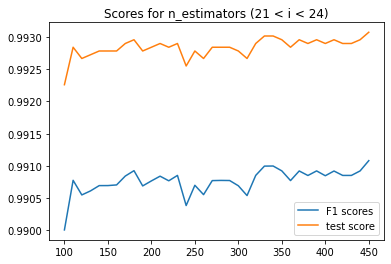

In [42]:
plt.plot(estimators2, f1_lst_e2, label='F1 scores')
plt.plot(estimators2, test_score_e2, label='test score')
plt.title('Scores for n_estimators (21 < i < 24)')
plt.legend()
plt.show()

In [54]:
df_e2 = pd.DataFrame({'n_estimator': estimators2, 'F1 score': f1_lst_e2})
df_e2 = df_e2.sort_values(by='F1 score', ascending=False)
print(df_e2.head(10))

    n_estimator  F1 score
21          310  0.993113
20          300  0.993113
22          320  0.993113
18          280  0.993104
19          290  0.992979
25          350  0.992884
24          340  0.992761
23          330  0.992761
17          270  0.992756
8           180  0.992622


In [28]:
depths2, f1_lst_depth2, train_score_depth2, test_score_depth2 = depth_params(X_drop_between_copy, Y_drop_between, 2, 26, 230)

2 1.0 1.0 1.0
3 1.0 1.0 1.0
4 1.0 1.0 1.0
5 1.0 1.0 1.0
6 1.0 1.0 1.0


KeyboardInterrupt: 

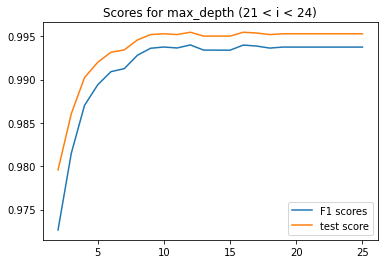

In [56]:
plt.plot(depths2, f1_lst_depth2, label='F1 scores')
plt.plot(depths2, test_score_depth2, label='test score')
plt.title('Scores for max_depth (21 < i < 24)')
plt.legend()
plt.show()

In [57]:
df_depth2 = pd.DataFrame({'max_depth': depths2, 'F1 score': f1_lst_depth2})
df_depth2 = df_depth2.sort_values(by='F1 score', ascending=False)
print(df_depth2.head(10))

    max_depth  F1 score
10         12  0.994006
14         16  0.993993
15         17  0.993875
8          10  0.993766
17         19  0.993761
23         25  0.993758
22         24  0.993758
21         23  0.993758
20         22  0.993758
19         21  0.993758


In [59]:
leaves2, f1_lst_leaf2, train_score_leaf2, test_score_leaf2 = leaves_params(X_drop_between_copy, Y_drop_between, 2, 31, depth=12, n=310, step=1)

2 0.9999112153629452 0.9951167137640444 0.9935262553434369


KeyboardInterrupt: 

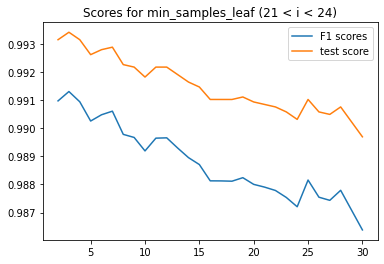

In [59]:
plt.plot(leaves2, f1_lst_leaf2, label='F1 scores')
plt.plot(leaves2, test_score_leaf2, label='test score')
plt.title('Scores for min_samples_leaf (21 < i < 24)')
plt.legend()
plt.show()

In [60]:
df_leaf2 = pd.DataFrame({'min_samples_leaf': leaves2, 'F1 score': f1_lst_leaf2})
df_leaf2 = df_leaf2.sort_values(by='F1 score', ascending=False)
print(df_leaf2.head(10))

    min_samples_leaf  F1 score
1                  3  0.991315
0                  2  0.990981
2                  4  0.990949
5                  7  0.990615
4                  6  0.990487
3                  5  0.990264
6                  8  0.989788
7                  9  0.989678
10                12  0.989664
9                 11  0.989653


In [61]:
splits2, f1_lst_split2, train_score_split2, test_score_split2 = split_params(X_drop_between_copy, Y_drop_between, 2, 31, n=110, depth=12, leaf=3, step=1)

2 0.999299576076108 0.9934296399848069 0.9913152844995003
3 0.999299576076108 0.9934296399848069 0.9913152844995003
4 0.999299576076108 0.9934296399848069 0.9913152844995003
5 0.999299576076108 0.9934296399848069 0.9913152844995003
6 0.999299576076108 0.9934296399848069 0.9913152844995003
7 0.9991811920182062 0.9928970955128518 0.9906315064587565
8 0.9991417326120701 0.9930744001979509 0.9908488663624766
9 0.9990529479750154 0.9929856690533191 0.9907145837059865
10 0.9989542975131777 0.9932520988934612 0.9910896163288365
11 0.9988951054842268 0.9934297187868892 0.9913391041057065
12 0.9987767233728231 0.9930746366041976 0.9908638682814865
13 0.998776724346072 0.9929857478554013 0.9907359477058609
14 0.9986188818552835 0.9935185287336032 0.9914436375130684
15 0.9986090150572517 0.9932522564976258 0.9910891954891637
16 0.9985202323666946 0.9930747942083622 0.9908554868303016
17 0.9983722547274401 0.9928081279619733 0.9905127279670143
18 0.998421581904857 0.992897095512852 0.9906353712772

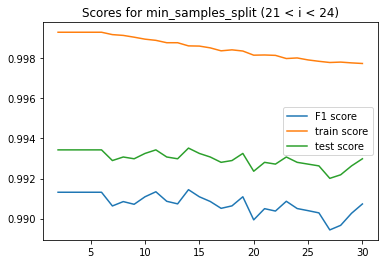

In [62]:
plt.plot(splits2, f1_lst_split2, label='F1 score')
plt.plot(splits2, train_score_split2, label='train score')
plt.plot(splits2, test_score_split2, label='test score')
plt.title('Scores for min_samples_split (21 < i < 24)')
plt.legend()
plt.show()

In [63]:
# get the top 10 min_samples_split with the highest F1 scores
df_split2 = pd.DataFrame({'min_samples_split': splits2, 'F1 score': f1_lst_split2})
df_split2 = df_split2.sort_values(by='F1 score', ascending=False)
print(df_split2.head(10))

    min_samples_split  F1 score
12                 14  0.991444
9                  11  0.991339
0                   2  0.991315
2                   4  0.991315
3                   5  0.991315
4                   6  0.991315
1                   3  0.991315
8                  10  0.991090
17                 19  0.991090
13                 15  0.991089


In [29]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_drop_between_copy, Y_drop_between, train_size=0.7, test_size=0.3, shuffle=True, random_state=42)

In [30]:
print(len(X_train2[0]))

15


In [31]:
# training using GridSearch
'''
model_params2 = {'n_estimators': [400, 300, 320, 280, 290, 350, 340, 330, 310, 180, 270, 420, 430, 120, 150],
                'max_features': ['auto', 'sqrt', 'log2'],
                'min_samples_split': [2, 4, 5, 6, 3, 10, 11, 14, 15],
                'min_samples_leaf': [3, 2, 4, 5, 7, 6],
                'max_depth': [12, 11, 15, 10, 13, 5, 6, 8, 9, 17]} # try to constrain the max_depth in [5, 15] https://stats.stackexchange.com/questions/111968/random-forest-how-to-handle-overfitting
'''
# class_weight? like certain color ratios are more important than others?
# oob_score = True

model_params2 = {'n_estimators': [i for i in range(100, 460, 10)],
                'max_features': ['auto', 'sqrt', 'log2'],
                'min_samples_split': [2, 4, 5, 6, 3, 10, 11, 14, 15],
                'min_samples_leaf': [3, 2, 4, 5, 7, 6],
                'max_depth': [12, 11, 15, 10, 13, 5, 6, 8, 9, 17]}

clf2 = RandomForestClassifier(random_state=42)

rf2 = RandomizedSearchCV(estimator = clf2, param_distributions = model_params2, n_iter = 100, cv = 5, scoring='f1_macro', refit= 'f1_macro', verbose=1, random_state=42, n_jobs = -1)

rf2.fit(X_train2, y_train2)

print('best params:\n ')
print(rf2.best_params_)

print('best score: \n ')
print(rf2.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best params:
 
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 17}
best score: 
 
1.0


## Test

In [32]:
qso_test = pd.read_csv('quasar_test_catalog.csv', index_col=False)
qso_test = qso_test[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_test.describe()

,r_LSST_mag,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,65.648371,56.107987,48.140213,35.209410,33.953109,34.408229,37.056265
std,34.999899,34.613620,32.917434,23.354992,21.852365,22.439000,25.883666
min,23.737275,21.400500,18.803401,18.181244,18.048911,17.986569,17.740505
25%,29.821013,28.555122,27.003421,25.704790,25.564225,25.613446,25.462108
50%,99.990000,29.953924,28.268598,27.587399,27.489070,27.495992,27.226590
75%,99.990000,99.990000,99.990000,28.891448,28.744201,28.762242,28.663621
max,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000


In [33]:
galaxies_patch8788_partial = read_data_partial('galaxies_train_catalog_patch8788.csv', 'galaxies_patch8788_partial.csv')
print('galaxies_train_catalog_patch8788.csv partial data description: ')
galaxies_patch8788_partial.describe()

galaxies_train_catalog_patch8788.csv partial data description: 


,ra_d,dec_d,z,redsq_flag,u_LSST_mag,u_LSST_magerr,g_LSST_mag,g_LSST_magerr,r_LSST_mag,r_LSST_magerr,...,z_LSST_mag,z_LSST_magerr,Y_WFI_mag,Y_WFI_magerr,J_WFI_mag,J_WFI_magerr,H_WFI_mag,H_WFI_magerr,F_WFI_mag,F_WFI_magerr
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,...,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,23.756580,-22.336886,1.032695,0.206810,31.865539,1.664620,27.095620,0.426634,25.869858,0.090803,...,24.651582,0.116117,24.353000,0.046214,24.208583,0.041196,24.100513,0.040888,24.039632,0.071686
std,13.727285,13.457052,0.014251,0.405028,19.671504,67.272044,7.854143,20.170242,2.970428,0.466100,...,2.711824,1.867361,1.421210,0.052759,1.359922,0.039060,1.408869,0.076789,1.551048,0.674135
min,0.005785,-47.497992,1.005989,0.000000,20.799293,0.000000,20.945724,0.000000,20.964661,0.000000,...,20.199310,0.000000,19.730171,0.000000,19.315425,0.010143,18.971169,0.010027,18.750817,0.000000
25%,11.733755,-33.606524,1.020423,0.000000,25.247719,0.058302,25.311052,0.035975,24.941155,0.026174,...,23.824312,0.032802,23.596931,0.019817,23.429763,0.018021,23.301662,0.017404,23.219071,0.022461
50%,23.895896,-21.660677,1.034144,0.000000,26.489127,0.194314,26.391954,0.081985,25.913941,0.049719,...,24.704255,0.061873,24.515632,0.032787,24.393318,0.029589,24.310903,0.028905,24.255154,0.042657
75%,35.661293,-10.672523,1.045282,0.000000,27.598871,0.474694,27.330566,0.178909,26.697344,0.091973,...,25.455755,0.114201,25.268753,0.056047,25.168173,0.049974,25.108181,0.049543,25.070309,0.079083
max,47.496031,-0.000724,1.055212,1.000000,99.990000,9080.560484,99.990000,2753.077529,99.990000,43.286299,...,99.990000,251.215935,99.990000,4.157023,29.046655,1.527037,30.885336,9.494070,99.990000,82.927110


In [34]:
galaxies_patch8788_partial = galaxies_patch8788_partial[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
print(galaxies_patch8788_partial.head())

   r_LSST_mag  i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  \
0   25.620305   25.035081   24.485231  24.423544  24.362241  24.324362   
1   25.230872   24.969824   24.395539  24.525811  24.546824  24.499536   
2   22.512334   22.275706   21.872768  21.677942  21.504141  21.340062   
3   27.865488   27.073493   26.192273  25.807305  25.627332  25.391634   
4   26.384361   25.518046   24.590732  24.114798  23.795983  23.585326   

   F_WFI_mag  
0  24.268830  
1  24.562695  
2  21.221775  
3  25.310328  
4  23.490337  


In [35]:
mlt_test = read_data_partial('mlt_test_catalog_max24.csv', 'mlt_test_catalog_partial.csv', )
mlt_test = mlt_test[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
print('mlt_test_catalog partial data description: ')
mlt_test.describe()

mlt_test_catalog partial data description: 


,r_LSST_mag,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,26.926689,22.174019,21.164776,20.363206,20.066301,19.937946,20.002332
std,0.200677,0.120493,0.161657,0.162586,0.162807,0.163030,0.163780
min,26.194485,22.000014,20.394267,19.725846,19.393827,19.264649,19.362965
25%,26.789641,22.074817,21.055488,20.253683,19.957080,19.826876,19.891932
50%,26.918773,22.155908,21.169774,20.367118,20.068748,19.941408,20.005348
75%,27.056720,22.254488,21.277619,20.477338,20.180303,20.051468,20.116187
max,27.905773,22.687161,21.753210,21.182426,20.963738,20.801828,20.993568


In [36]:
qso_test_copy = qso_test.copy()
qso_test_copy['label'] = np.ones(len(qso_test_copy))
galaxies_patch8788_pcopy = galaxies_patch8788_partial.copy()
galaxies_patch8788_pcopy['label'] = np.zeros(len(galaxies_patch8788_pcopy))
test_wgal = pd.concat([qso_test_copy, galaxies_patch8788_pcopy], ignore_index=True)
print(test_wgal.describe())

         r_LSST_mag    i_LSST_mag    z_LSST_mag     Y_WFI_mag     J_WFI_mag  \
count  44999.000000  44999.000000  44999.000000  44999.000000  44999.000000   
mean      47.969523     42.385887     37.701112     30.384473     29.622329   
std       32.789956     30.056330     27.230051     18.249165     17.016506   
min       20.964661     20.738443     18.803401     18.181244     18.048911   
25%       26.108564     25.457826     24.589408     24.219371     24.089289   
50%       29.098091     27.776565     26.166768     25.565317     25.455884   
75%       99.990000     30.578948     28.596754     27.841186     27.743223   
max       99.990000     99.990000     99.990000     99.990000     99.990000   

          H_WFI_mag     F_WFI_mag         label  
count  44999.000000  44999.000000  44999.000000  
mean      29.827149     31.271255      0.555568  
std       17.516998     20.374225      0.496908  
min       17.986569     17.740505      0.000000  
25%       24.026803     23.936007     

In [37]:
mlt_test_copy = mlt_test.copy()
mlt_test_copy['label'] = np.zeros(len(mlt_test_copy))
test = pd.concat([qso_test_copy, galaxies_patch8788_pcopy, mlt_test_copy], ignore_index=True)
test.describe()

,r_LSST_mag,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label
count,64998.000000,64998.000000,64998.000000,64998.000000,64998.000000,64998.000000,64998.000000,64998.000000
mean,41.494929,36.166971,32.613106,27.301066,26.682069,26.784376,27.803961,0.384627
std,28.960228,26.691700,23.907913,15.873303,14.829919,15.273254,17.732538,0.486511
min,20.964661,20.738443,18.803401,18.181244,18.048911,17.986569,17.740505,0.000000
25%,26.648108,22.273506,21.303424,20.507608,20.211694,20.081580,20.145379,0.000000
50%,27.078660,25.629694,24.755012,24.373978,24.249103,24.193706,24.115527,0.000000
75%,30.470443,29.011888,27.579617,26.698436,26.583893,26.606885,26.459749,1.000000
max,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000,1.000000


{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}

{'n_estimators': 430, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 11}

or

{'n_estimators': 430, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 13}

{'n_estimators': 230, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 13}

22 < i < 24

In [38]:
clf2 = RandomForestClassifier(n_estimators=200, min_samples_split=4, min_samples_leaf=3, max_features='log2', max_depth=17)
clf2.fit(X_drop_between_copy, Y_drop_between)

RandomForestClassifier(max_depth=17, max_features='log2', min_samples_leaf=3,
                       min_samples_split=4, n_estimators=200)

with galaxies added

In [58]:
test_wgal_copy = test_wgal.copy()
test_wgal_copy = test_wgal_copy.drop(columns=['label'])
test_wgal_copy = test_wgal_copy[test_wgal_copy['i_LSST_mag'] > 22.0]
test_wgal_copy = test_wgal_copy[test_wgal_copy['i_LSST_mag'] < 24.0]
print(len(test_wgal_copy))

3417


In [59]:
print(test_wgal_copy.head())

      r_LSST_mag  i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  \
595    26.283738   23.617095   20.988860  20.683242  20.747272  20.776251   
640    25.920754   23.591678   20.736045  20.487876  20.522353  20.487307   
1287   25.816063   22.662278   19.998339  19.667473  19.669087  19.659937   
1557   27.731326   23.963253   21.542414  20.239541  20.205948  20.241758   
1739   24.438664   22.427320   19.950788  19.426217  19.408946  19.447905   

      F_WFI_mag  
595   20.615905  
640   20.272406  
1287  19.460619  
1557  20.131784  
1739  19.296234  


In [60]:
col_names = ['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']
for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i < j:
            col = col_names[i] + '-' + col_names[j]
            test_wgal_copy[col] = test_wgal_copy[col_names[i]] - test_wgal_copy[col_names[j]]

In [61]:
test_wgal_copy = test_wgal_copy[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'Y_WFI_mag-H_WFI_mag', 'Y_WFI_mag-F_WFI_mag', 'z_LSST_mag-H_WFI_mag', 'z_LSST_mag-F_WFI_mag', 'i_LSST_mag-z_LSST_mag', 'r_LSST_mag-z_LSST_mag', 'i_LSST_mag-Y_WFI_mag', 'r_LSST_mag-Y_WFI_mag']]

In [62]:
len(test_wgal_copy)

3417

In [63]:
labels = clf2.predict(test_wgal_copy.to_numpy())
print(labels)
test2 = test_wgal.drop(columns=['label'])
test2 = test2[test2['i_LSST_mag'] > 22.0]
test2 = test2[test2['i_LSST_mag'] < 24.0]
test2['label'] = labels
test2 = test2[test2['label'] == 1]
print(len(test2))

[0 0 0 ... 0 0 0]
12


In [64]:
qso_test_between = test_wgal[test_wgal['i_LSST_mag'] > 22.0]
qso_test_between = qso_test_between[qso_test_between['i_LSST_mag'] < 24.0]
qso_test_between = qso_test_between[qso_test_between['label'] == 1]
print(len(qso_test_between))
print(set(test2).issubset(qso_test_between))

53
True


with galaxies and brown dwarfs added

In [65]:
test_copy = test.copy()
test_copy = test_copy.drop(columns=['label'])
test_copy = test_copy[test_copy['i_LSST_mag'] > 22.0]
test_copy = test_copy[test_copy['i_LSST_mag'] < 24.0]
print(len(test_copy))

23416


In [66]:
col_names = ['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']
for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i < j:
            col = col_names[i] + '-' + col_names[j]
            test_copy[col] = test_copy[col_names[i]] - test_copy[col_names[j]]

In [67]:
test_copy = test_copy[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'Y_WFI_mag-H_WFI_mag', 'Y_WFI_mag-F_WFI_mag', 'z_LSST_mag-H_WFI_mag', 'z_LSST_mag-F_WFI_mag', 'i_LSST_mag-z_LSST_mag', 'r_LSST_mag-z_LSST_mag', 'i_LSST_mag-Y_WFI_mag', 'r_LSST_mag-Y_WFI_mag']]

In [69]:
labels3 = clf2.predict(test_copy.to_numpy()) 
test3 = test.drop(columns=['label'])
test3 = test3[test3['i_LSST_mag'] > 22.0]
test3 = test3[test3['i_LSST_mag'] < 24.0]
test3['label'] = labels3
test3 = test3[test3['label'] == 1]
print(len(test3))

12


In [70]:
print(set(test3).issubset(qso_test_between))

True


### with noise without replacements

22 < i < 24

In [23]:
for col in X_drop_between_copy.columns:
    noise = np.random.normal(X_drop_between_copy[col].mean(), X_drop_between_copy[col].std(), len(X_drop_between_copy[col]))
    X_drop_between_copy[col] = X_drop_between_copy[col] + noise

In [24]:
X_drop_between_copy = X_drop_between_copy.to_numpy()
Y_drop_between = np.array(Y_drop_between, dtype=int)

In [25]:
print(len(X_drop_between_copy[0]))

15


In [26]:
estimators2, f1_lst_e2, train_score_e2, test_score_e2 = estimator_params(X_drop_between_copy, Y_drop_between, 100, 460, step=10)

100 1.0 0.9984643338608523 0.9967504261572874
110 1.0 0.9984643338608523 0.9967470886520724
120 1.0 0.9985823976152798 0.9969846103970209
130 1.0 0.9985823976152798 0.9969846103970209
140 1.0 0.9985823976152798 0.9969834926476329
150 1.0 0.998464194305587 0.9967172923223343
160 1.0 0.998464194305587 0.9967172923223343
170 1.0 0.998464194305587 0.9967172923223343
180 1.0 0.998464194305587 0.9967172923223343
190 1.0 0.998464194305587 0.9967172923223343
200 1.0 0.9982280667967324 0.9962238289812966
210 1.0 0.9983461305511596 0.9964808883267737
220 1.0 0.9982280667967324 0.9962238289812966
230 1.0 0.9982280667967324 0.9962238289812966
240 1.0 0.9982280667967324 0.9962238289812966
250 1.0 0.9982280667967324 0.9962238289812966
260 1.0 0.9985823976152798 0.9969846103970209
270 1.0 0.998464194305587 0.9967150725665075
280 1.0 0.9982280667967324 0.9962238289812966
290 1.0 0.9983462701064247 0.99649336681181
300 1.0 0.9983462701064247 0.99649336681181
310 1.0 0.9983462701064247 0.99649336681181


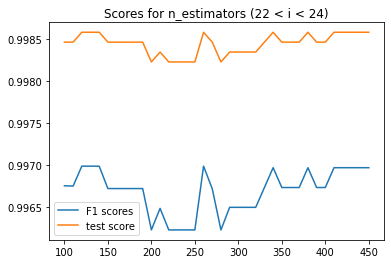

In [27]:
plt.plot(estimators2, f1_lst_e2, label='F1 scores')
plt.plot(estimators2, test_score_e2, label='test score')
plt.title('Scores for n_estimators (22 < i < 24)')
plt.legend()
plt.show()

In [35]:
df_e2 = pd.DataFrame({'n_estimator': estimators2, 'F1 score': f1_lst_e2})
df_e2 = df_e2.sort_values(by='F1 score', ascending=False)
print(df_e2.head(15))

    n_estimator  F1 score
16          260  0.996985
2           120  0.996985
3           130  0.996985
4           140  0.996983
35          450  0.996966
34          440  0.996966
33          430  0.996966
32          420  0.996966
31          410  0.996966
28          380  0.996966
24          340  0.996966
0           100  0.996750
1           110  0.996747
23          330  0.996730
30          400  0.996730


In [31]:
depths2, f1_lst_depth2, train_score_depth2, test_score_depth2 = depth_params(X_drop_between_copy, Y_drop_between, 2, 26, 260)

2 0.9853120907780155 0.9836989681283687 0.9637832918919983
3 0.9946052346438348 0.9925576572578505 0.983937988144396
4 0.9973879381081916 0.9962198665293445 0.9919669504951587
5 0.9985036458886636 0.9971650743410898 0.9940009843514543
6 0.9987399094255629 0.9976376084693299 0.9949473200532765
7 0.9992386952779443 0.9979919392878773 0.9956948312225412
8 0.9993568330765574 0.9982280667967321 0.9961654194578354
9 0.9995537196444575 0.998464194305587 0.9966654475844174
10 0.9996587237465194 0.9983461305511596 0.9964312633446838
11 0.9996981024384224 0.9982280667967321 0.9961793741759181
12 0.9997768598222286 0.9985822580600143 0.9969225069298948
13 0.9998949958979383 0.9985823976152798 0.9969760941331673
14 1.0 0.9983461305511596 0.9964808883267737
15 1.0 0.9983461305511596 0.9964580132210301
16 1.0 0.9983461305511596 0.9964808883267737
17 1.0 0.9983461305511596 0.9964808883267737
18 1.0 0.9985823976152798 0.9969846103970209
19 1.0 0.9985823976152798 0.9969846103970209
20 1.0 0.99858239761

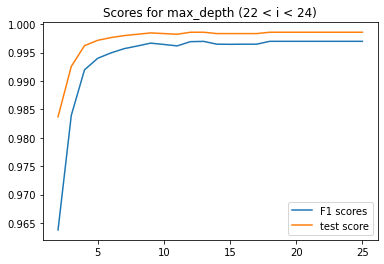

In [32]:
plt.plot(depths2, f1_lst_depth2, label='F1 scores')
plt.plot(depths2, test_score_depth2, label='test score')
plt.title('Scores for max_depth (22 < i < 24)')
plt.legend()
plt.show()

In [34]:
df_depth2 = pd.DataFrame({'max_depth': depths2, 'F1 score': f1_lst_depth2})
df_depth2 = df_depth2.sort_values(by='F1 score', ascending=False)
print(df_depth2.head(15))

    max_depth  F1 score
23         25  0.996985
22         24  0.996985
21         23  0.996985
20         22  0.996985
19         21  0.996985
18         20  0.996985
17         19  0.996985
16         18  0.996985
11         13  0.996976
10         12  0.996923
7           9  0.996665
14         16  0.996481
15         17  0.996481
12         14  0.996481
13         15  0.996458


In [36]:
leaves2, f1_lst_leaf2, train_score_leaf2, test_score_leaf2 = leaves_params(X_drop_between_copy, Y_drop_between, 2, 31, depth=13, n=260, step=1)

2 0.9997374828532294 0.9984643338608523 0.9967297708073705
3 0.9995930948905526 0.998464194305587 0.9966654475844174
4 0.9994355835687481 0.9983461305511596 0.9964312633446838
5 0.9994224567638124 0.9981100030423047 0.9959467203913069
6 0.9993699547127814 0.9981100030423047 0.995929015462275
7 0.9993699547127814 0.9982280667967321 0.9961831243868675
8 0.9992780774156552 0.9979919392878773 0.9957231612359159
9 0.9992255701959124 0.9976374689140647 0.9949330168580452
10 0.9991993183089448 0.9979917997326122 0.9956709073352498
11 0.9991205609251388 0.9978737359781847 0.995436723095516
12 0.9990680554282999 0.9979917997326122 0.9956848620533325
13 0.9989892980444937 0.9976374689140647 0.9949580834742662
14 0.9990024265723333 0.9978737359781847 0.9954329728845668
15 0.9989236709114309 0.9976376084693299 0.9949316725904656
16 0.9988580403325603 0.9974012018499445 0.9944771456653505
17 0.9988317849997849 0.9976374689140647 0.9949580834742662
18 0.9987530293388825 0.9974012018499445 0.99449613

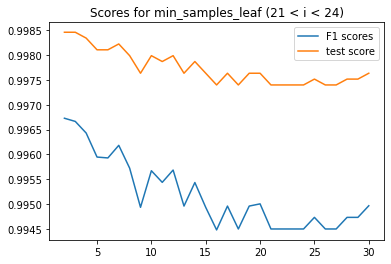

In [37]:
plt.plot(leaves2, f1_lst_leaf2, label='F1 scores')
plt.plot(leaves2, test_score_leaf2, label='test score')
plt.title('Scores for min_samples_leaf (21 < i < 24)')
plt.legend()
plt.show()

In [38]:
df_leaf2 = pd.DataFrame({'min_samples_leaf': leaves2, 'F1 score': f1_lst_leaf2})
df_leaf2 = df_leaf2.sort_values(by='F1 score', ascending=False)
print(df_leaf2.head(10))

    min_samples_leaf  F1 score
0                  2  0.996730
1                  3  0.996665
2                  4  0.996431
5                  7  0.996183
3                  5  0.995947
4                  6  0.995929
6                  8  0.995723
10                12  0.995685
8                 10  0.995671
9                 11  0.995437


In [39]:
splits2, f1_lst_split2, train_score_split2, test_score_split2 = split_params(X_drop_between_copy, Y_drop_between, 2, 31, n=260, depth=13, leaf=2, step=1)

2 0.9997374828532294 0.9984643338608523 0.9967297708073705
3 0.9997374828532294 0.9984643338608523 0.9967297708073705
4 0.9997374828532294 0.9984643338608523 0.9967297708073705
5 0.9997112292433581 0.9985823976152798 0.996963955047104
6 0.999711232689166 0.9984643338608523 0.9967297708073705
7 0.9996981041613264 0.9985823976152798 0.996963955047104
8 0.9996981041613264 0.998464194305587 0.9966654475844174
9 0.9996456003873915 0.998464194305587 0.9966654475844174
10 0.9996324701366481 0.998464194305587 0.9966654475844174
11 0.9995799698085209 0.9983461305511596 0.9964290435888572
12 0.9995143409525544 0.9985823976152798 0.996963955047104
13 0.9995012141476186 0.9983462701064247 0.9964778816386047
14 0.9995012141476186 0.9983462701064247 0.996481631849554
15 0.999488089065587 0.9982280667967321 0.9961831243868675
16 0.9994749622606512 0.9982280667967321 0.9961809046310407
17 0.9994224584867164 0.9982280667967321 0.9961948593491234
18 0.9994093316817807 0.9983461305511596 0.99643126334468

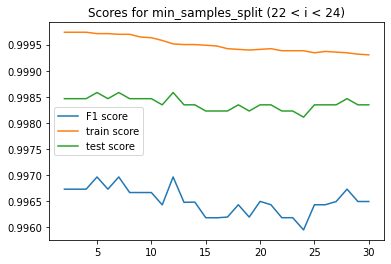

In [40]:
plt.plot(splits2, f1_lst_split2, label='F1 score')
plt.plot(splits2, train_score_split2, label='train score')
plt.plot(splits2, test_score_split2, label='test score')
plt.title('Scores for min_samples_split (22 < i < 24)')
plt.legend()
plt.show()

In [41]:
# get the top 10 min_samples_split with the highest F1 scores
df_split2 = pd.DataFrame({'min_samples_split': splits2, 'F1 score': f1_lst_split2})
df_split2 = df_split2.sort_values(by='F1 score', ascending=False)
print(df_split2.head(10))

    min_samples_split  F1 score
3                   5  0.996964
5                   7  0.996964
10                 12  0.996964
0                   2  0.996730
1                   3  0.996730
2                   4  0.996730
4                   6  0.996730
26                 28  0.996730
6                   8  0.996665
7                   9  0.996665


In [42]:
# _n: noise
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_drop_between_copy, Y_drop_between, train_size=0.7, test_size=0.3, shuffle=True, random_state=42)

In [43]:
model_params_n = {'n_estimators': [120, 130, 140, 420, 430, 380, 330, 340, 400, 100, 260],
                'max_features': ['auto', 'sqrt', 'log2'],
                'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 12],
                'min_samples_leaf': [2, 3, 4, 6, 7, 8, 5, 10, 11, 12],
                'max_depth': [12, 11, 15, 10, 13, 5, 6, 8, 9, 17]}

clf_n = RandomForestClassifier(random_state=42)

rf_n = RandomizedSearchCV(estimator = clf_n, param_distributions = model_params_n, n_iter = 100, cv = 5, scoring='f1_macro', refit= 'f1_macro', verbose=1, random_state=42, n_jobs = -1)

rf_n.fit(X_train_n, y_train_n)

print('best params:\n ')
print(rf_n.best_params_)

print('best score: \n ')
print(rf_n.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best params:
 
{'n_estimators': 380, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 12}
best score: 
 
0.9980629204629652


## Test

In [44]:
qso_test = pd.read_csv('quasar_test_catalog.csv', index_col=False)
qso_test = qso_test[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_test.describe()

,r_LSST_mag,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,65.648371,56.107987,48.140213,35.209410,33.953109,34.408229,37.056265
std,34.999899,34.613620,32.917434,23.354992,21.852365,22.439000,25.883666
min,23.737275,21.400500,18.803401,18.181244,18.048911,17.986569,17.740505
25%,29.821013,28.555122,27.003421,25.704790,25.564225,25.613446,25.462108
50%,99.990000,29.953924,28.268598,27.587399,27.489070,27.495992,27.226590
75%,99.990000,99.990000,99.990000,28.891448,28.744201,28.762242,28.663621
max,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000


In [45]:
galaxies_patch8788_partial = read_data_partial('galaxies_train_catalog_patch8788.csv', 'galaxies_patch8788_partial.csv')
print('galaxies_train_catalog_patch8788.csv partial data description: ')
galaxies_patch8788_partial.describe()

galaxies_train_catalog_patch8788.csv partial data description: 


,ra_d,dec_d,z,redsq_flag,u_LSST_mag,u_LSST_magerr,g_LSST_mag,g_LSST_magerr,r_LSST_mag,r_LSST_magerr,...,z_LSST_mag,z_LSST_magerr,Y_WFI_mag,Y_WFI_magerr,J_WFI_mag,J_WFI_magerr,H_WFI_mag,H_WFI_magerr,F_WFI_mag,F_WFI_magerr
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,...,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,23.756580,-22.336886,1.032695,0.206810,31.865539,1.664620,27.095620,0.426634,25.869858,0.090803,...,24.651582,0.116117,24.353000,0.046214,24.208583,0.041196,24.100513,0.040888,24.039632,0.071686
std,13.727285,13.457052,0.014251,0.405028,19.671504,67.272044,7.854143,20.170242,2.970428,0.466100,...,2.711824,1.867361,1.421210,0.052759,1.359922,0.039060,1.408869,0.076789,1.551048,0.674135
min,0.005785,-47.497992,1.005989,0.000000,20.799293,0.000000,20.945724,0.000000,20.964661,0.000000,...,20.199310,0.000000,19.730171,0.000000,19.315425,0.010143,18.971169,0.010027,18.750817,0.000000
25%,11.733755,-33.606524,1.020423,0.000000,25.247719,0.058302,25.311052,0.035975,24.941155,0.026174,...,23.824312,0.032802,23.596931,0.019817,23.429763,0.018021,23.301662,0.017404,23.219071,0.022461
50%,23.895896,-21.660677,1.034144,0.000000,26.489127,0.194314,26.391954,0.081985,25.913941,0.049719,...,24.704255,0.061873,24.515632,0.032787,24.393318,0.029589,24.310903,0.028905,24.255154,0.042657
75%,35.661293,-10.672523,1.045282,0.000000,27.598871,0.474694,27.330566,0.178909,26.697344,0.091973,...,25.455755,0.114201,25.268753,0.056047,25.168173,0.049974,25.108181,0.049543,25.070309,0.079083
max,47.496031,-0.000724,1.055212,1.000000,99.990000,9080.560484,99.990000,2753.077529,99.990000,43.286299,...,99.990000,251.215935,99.990000,4.157023,29.046655,1.527037,30.885336,9.494070,99.990000,82.927110


In [46]:
galaxies_patch8788_partial = galaxies_patch8788_partial[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
print(galaxies_patch8788_partial.head())

   r_LSST_mag  i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  \
0   25.620305   25.035081   24.485231  24.423544  24.362241  24.324362   
1   25.230872   24.969824   24.395539  24.525811  24.546824  24.499536   
2   22.512334   22.275706   21.872768  21.677942  21.504141  21.340062   
3   27.865488   27.073493   26.192273  25.807305  25.627332  25.391634   
4   26.384361   25.518046   24.590732  24.114798  23.795983  23.585326   

   F_WFI_mag  
0  24.268830  
1  24.562695  
2  21.221775  
3  25.310328  
4  23.490337  


In [47]:
mlt_test = read_data_partial('mlt_test_catalog_max24.csv', 'mlt_test_catalog_partial.csv', )
mlt_test = mlt_test[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
print('mlt_test_catalog partial data description: ')
mlt_test.describe()

mlt_test_catalog partial data description: 


,r_LSST_mag,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,26.926689,22.174019,21.164776,20.363206,20.066301,19.937946,20.002332
std,0.200677,0.120493,0.161657,0.162586,0.162807,0.163030,0.163780
min,26.194485,22.000014,20.394267,19.725846,19.393827,19.264649,19.362965
25%,26.789641,22.074817,21.055488,20.253683,19.957080,19.826876,19.891932
50%,26.918773,22.155908,21.169774,20.367118,20.068748,19.941408,20.005348
75%,27.056720,22.254488,21.277619,20.477338,20.180303,20.051468,20.116187
max,27.905773,22.687161,21.753210,21.182426,20.963738,20.801828,20.993568


In [48]:
qso_test_copy = qso_test.copy()
qso_test_copy['label'] = np.ones(len(qso_test_copy))
galaxies_patch8788_pcopy = galaxies_patch8788_partial.copy()
galaxies_patch8788_pcopy['label'] = np.zeros(len(galaxies_patch8788_pcopy))
test_wgal = pd.concat([qso_test_copy, galaxies_patch8788_pcopy], ignore_index=True)
print(test_wgal.describe())

         r_LSST_mag    i_LSST_mag    z_LSST_mag     Y_WFI_mag     J_WFI_mag  \
count  44999.000000  44999.000000  44999.000000  44999.000000  44999.000000   
mean      47.969523     42.385887     37.701112     30.384473     29.622329   
std       32.789956     30.056330     27.230051     18.249165     17.016506   
min       20.964661     20.738443     18.803401     18.181244     18.048911   
25%       26.108564     25.457826     24.589408     24.219371     24.089289   
50%       29.098091     27.776565     26.166768     25.565317     25.455884   
75%       99.990000     30.578948     28.596754     27.841186     27.743223   
max       99.990000     99.990000     99.990000     99.990000     99.990000   

          H_WFI_mag     F_WFI_mag         label  
count  44999.000000  44999.000000  44999.000000  
mean      29.827149     31.271255      0.555568  
std       17.516998     20.374225      0.496908  
min       17.986569     17.740505      0.000000  
25%       24.026803     23.936007     

In [49]:
mlt_test_copy = mlt_test.copy()
mlt_test_copy['label'] = np.zeros(len(mlt_test_copy))
test = pd.concat([qso_test_copy, galaxies_patch8788_pcopy, mlt_test_copy], ignore_index=True)
test.describe()

,r_LSST_mag,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag,label
count,64998.000000,64998.000000,64998.000000,64998.000000,64998.000000,64998.000000,64998.000000,64998.000000
mean,41.494929,36.166971,32.613106,27.301066,26.682069,26.784376,27.803961,0.384627
std,28.960228,26.691700,23.907913,15.873303,14.829919,15.273254,17.732538,0.486511
min,20.964661,20.738443,18.803401,18.181244,18.048911,17.986569,17.740505,0.000000
25%,26.648108,22.273506,21.303424,20.507608,20.211694,20.081580,20.145379,0.000000
50%,27.078660,25.629694,24.755012,24.373978,24.249103,24.193706,24.115527,0.000000
75%,30.470443,29.011888,27.579617,26.698436,26.583893,26.606885,26.459749,1.000000
max,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000,1.000000


22 < i < 24

{'n_estimators': 380, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 12}

In [50]:
clf_n = RandomForestClassifier(n_estimators=380, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=12)
clf_n.fit(X_drop_between_copy, Y_drop_between)

RandomForestClassifier(max_depth=12, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=380)

with galaxies added

In [51]:
test_wgal_copy = test_wgal.copy()
test_wgal_copy = test_wgal_copy.drop(columns=['label'])
test_wgal_copy = test_wgal_copy[test_wgal_copy['i_LSST_mag'] > 22.0]
test_wgal_copy = test_wgal_copy[test_wgal_copy['i_LSST_mag'] < 24.0]
print(len(test_wgal_copy))

3417


In [52]:
col_names = ['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']
for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i < j:
            col = col_names[i] + '-' + col_names[j]
            test_wgal_copy[col] = test_wgal_copy[col_names[i]] - test_wgal_copy[col_names[j]]

In [53]:
test_wgal_copy = test_wgal_copy[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'Y_WFI_mag-H_WFI_mag', 'Y_WFI_mag-F_WFI_mag', 'z_LSST_mag-H_WFI_mag', 'z_LSST_mag-F_WFI_mag', 'i_LSST_mag-z_LSST_mag', 'r_LSST_mag-z_LSST_mag', 'i_LSST_mag-Y_WFI_mag', 'r_LSST_mag-Y_WFI_mag']]

In [54]:
len(test_wgal_copy)

3417

In [55]:
labels = clf_n.predict(test_wgal_copy.to_numpy())
print(labels)
test2 = test_wgal.drop(columns=['label'])
test2 = test2[test2['i_LSST_mag'] > 22.0]
test2 = test2[test2['i_LSST_mag'] < 24.0]
test2['label'] = labels
test2 = test2[test2['label'] == 1]
print(len(test2))

[1 1 1 ... 0 0 0]
53


In [56]:
qso_test_between = test_wgal[test_wgal['i_LSST_mag'] > 22.0]
qso_test_between = qso_test_between[qso_test_between['i_LSST_mag'] < 24.0]
qso_test_between = qso_test_between[qso_test_between['label'] == 1]
print(len(qso_test_between))
print(set(test2).issubset(qso_test_between))

53
True


with galaxies and brown dwarfs added

In [57]:
test_copy = test.copy()
test_copy = test_copy.drop(columns=['label'])
test_copy = test_copy[test_copy['i_LSST_mag'] > 22.0]
test_copy = test_copy[test_copy['i_LSST_mag'] < 24.0]
print(len(test_copy))

23416


In [58]:
col_names = ['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']
for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i < j:
            col = col_names[i] + '-' + col_names[j]
            test_copy[col] = test_copy[col_names[i]] - test_copy[col_names[j]]

In [59]:
test_copy = test_copy[['r_LSST_mag', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'Y_WFI_mag-H_WFI_mag', 'Y_WFI_mag-F_WFI_mag', 'z_LSST_mag-H_WFI_mag', 'z_LSST_mag-F_WFI_mag', 'i_LSST_mag-z_LSST_mag', 'r_LSST_mag-z_LSST_mag', 'i_LSST_mag-Y_WFI_mag', 'r_LSST_mag-Y_WFI_mag']]

In [60]:
labels3 = clf_n.predict(test_copy.to_numpy()) 
test3 = test.drop(columns=['label'])
test3 = test3[test3['i_LSST_mag'] > 22.0]
test3 = test3[test3['i_LSST_mag'] < 24.0]
test3['label'] = labels3
test3 = test3[test3['label'] == 1]
print(len(test3))

20036


In [70]:
print(set(test3).issubset(qso_test_between))

True
